Mounting Google Drive

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive /Colab Notebooks/Session 7')

In [ ]:
pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2

Updating Device to CUDA

In [2]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")

CUDA Available? True


Importing custom modules

In [3]:
import utils
import model

In [4]:
from utils import *

In [5]:
from model import *

Defining data tranformations

In [6]:
# train_transforms = transforms.Compose([
#     transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#     transforms.RandomHorizontalFlip(p=0.3),
#     transforms.RandomRotation((-10., 10.), fill=1),
# #     horizontal flip
# #      shiftScaleRotate
# #     coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ])

train_transforms = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.HorizontalFlip(p=0.1),
        A.CoarseDropout (max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=.45, mask_fill_value = None),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)
test_transforms = A.Compose(
    [
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ]
)


Creating Custom Dataset class for CIFAR10 to support albumentation library

In [7]:
class cifar_ds10(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

Downloading CIFAR 10 dataset and splitting to train and test set

In [8]:
train_data = cifar_ds10('../data', train=True, download=True, transform=train_transforms)
test_data = cifar_ds10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:05<00:00, 29472197.60it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [9]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Creating Data Loaders from train data and test data

In [10]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

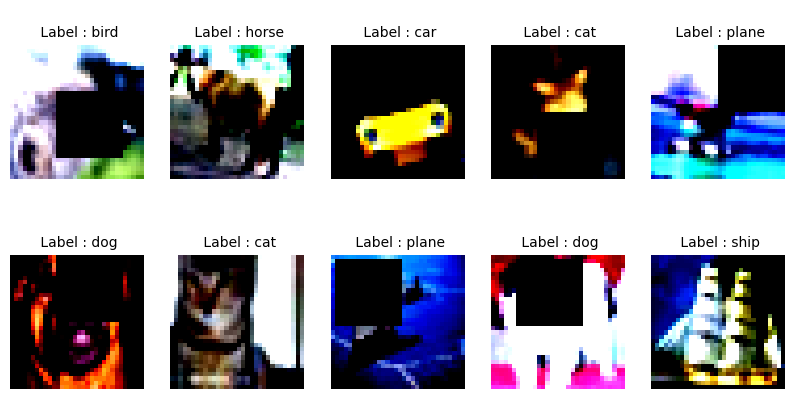

In [11]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images.shape)
# print(labels.shape)
# show images
num_of_images = 10
fig = plt.figure(figsize=(10,5))

for index in range(1, num_of_images+1):
    ax = fig.add_subplot(2, 5, index)
    ax.axis('off')
    actual = classes[labels[index]]
    ax.set_title(f'\n Label : {actual}',fontsize=10)
    ax.imshow(np.transpose(images[index], (1, 2, 0)))

Transferring model to GPU and printing model summary

In [15]:
model1 = Net_dilated(norm='BN').to(device)
summary(model1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 30, 30]          18,432
           Conv2d-10           [-1, 64, 30, 30]          36,864
             ReLU-11           [-1, 64, 30, 30]               0
      BatchNorm2d-12           [-1, 64, 30, 30]             128
          Dropout-13           [-1, 64, 30, 30]               0
           Conv2d-14           [-1, 32,

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Training and evaluating the model with BatchNorm2d layers

In [17]:
model1 =  Net_dilated(norm="BN").to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.10, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.10)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model1, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model1, device, test_loader)

EPOCH: 1


Loss=1.5701334476470947 Batch_id=390 Accuracy=34.01: 100%|██████████| 391/391 [00:22<00:00, 17.70it/s]



Test set: Average loss: 1.4407, Accuracy: 4723/10000 (47.23%)

EPOCH: 2


Loss=1.2148936986923218 Batch_id=390 Accuracy=47.08: 100%|██████████| 391/391 [00:20<00:00, 19.30it/s]



Test set: Average loss: 1.2533, Accuracy: 5460/10000 (54.60%)

EPOCH: 3


Loss=1.123183012008667 Batch_id=390 Accuracy=53.63: 100%|██████████| 391/391 [00:20<00:00, 19.12it/s]



Test set: Average loss: 1.0533, Accuracy: 6222/10000 (62.22%)

EPOCH: 4


Loss=0.9555904269218445 Batch_id=390 Accuracy=58.16: 100%|██████████| 391/391 [00:19<00:00, 19.71it/s]



Test set: Average loss: 1.2405, Accuracy: 5910/10000 (59.10%)

EPOCH: 5


Loss=1.1685768365859985 Batch_id=390 Accuracy=60.69: 100%|██████████| 391/391 [00:19<00:00, 19.88it/s]



Test set: Average loss: 0.9193, Accuracy: 6742/10000 (67.42%)

EPOCH: 6


Loss=0.9688360095024109 Batch_id=390 Accuracy=63.42: 100%|██████████| 391/391 [00:20<00:00, 18.93it/s]



Test set: Average loss: 0.8833, Accuracy: 6908/10000 (69.08%)

EPOCH: 7


Loss=1.1814504861831665 Batch_id=390 Accuracy=65.06: 100%|██████████| 391/391 [00:19<00:00, 19.89it/s]



Test set: Average loss: 0.8962, Accuracy: 6859/10000 (68.59%)

EPOCH: 8


Loss=0.7545276880264282 Batch_id=390 Accuracy=66.59: 100%|██████████| 391/391 [00:20<00:00, 18.98it/s]



Test set: Average loss: 0.7563, Accuracy: 7397/10000 (73.97%)

EPOCH: 9


Loss=0.9318749308586121 Batch_id=390 Accuracy=67.52: 100%|██████████| 391/391 [00:19<00:00, 19.95it/s]



Test set: Average loss: 0.8223, Accuracy: 7192/10000 (71.92%)

EPOCH: 10


Loss=0.8520811796188354 Batch_id=390 Accuracy=69.09: 100%|██████████| 391/391 [00:20<00:00, 18.74it/s]



Test set: Average loss: 0.7422, Accuracy: 7457/10000 (74.57%)

EPOCH: 11


Loss=0.887963593006134 Batch_id=390 Accuracy=69.98: 100%|██████████| 391/391 [00:19<00:00, 19.97it/s]



Test set: Average loss: 0.7631, Accuracy: 7421/10000 (74.21%)

EPOCH: 12


Loss=0.7471557855606079 Batch_id=390 Accuracy=71.09: 100%|██████████| 391/391 [00:19<00:00, 19.84it/s]



Test set: Average loss: 0.6727, Accuracy: 7701/10000 (77.01%)

EPOCH: 13


Loss=0.6656261682510376 Batch_id=390 Accuracy=71.93: 100%|██████████| 391/391 [00:20<00:00, 19.11it/s]



Test set: Average loss: 0.6596, Accuracy: 7743/10000 (77.43%)

EPOCH: 14


Loss=0.9162930250167847 Batch_id=390 Accuracy=72.39: 100%|██████████| 391/391 [00:19<00:00, 19.99it/s]



Test set: Average loss: 0.6364, Accuracy: 7795/10000 (77.95%)

EPOCH: 15


Loss=0.779501736164093 Batch_id=390 Accuracy=73.22: 100%|██████████| 391/391 [00:20<00:00, 18.75it/s]



Test set: Average loss: 0.5972, Accuracy: 7958/10000 (79.58%)

EPOCH: 16


Loss=0.8541314005851746 Batch_id=390 Accuracy=73.92: 100%|██████████| 391/391 [00:19<00:00, 19.83it/s]



Test set: Average loss: 0.5907, Accuracy: 7984/10000 (79.84%)

EPOCH: 17


Loss=0.6491730809211731 Batch_id=390 Accuracy=74.21: 100%|██████████| 391/391 [00:20<00:00, 18.67it/s]



Test set: Average loss: 0.5861, Accuracy: 7966/10000 (79.66%)

EPOCH: 18


Loss=0.8443471789360046 Batch_id=390 Accuracy=74.96: 100%|██████████| 391/391 [00:19<00:00, 20.13it/s]



Test set: Average loss: 0.5688, Accuracy: 8049/10000 (80.49%)

EPOCH: 19


Loss=0.9579159617424011 Batch_id=390 Accuracy=75.19: 100%|██████████| 391/391 [00:19<00:00, 19.80it/s]



Test set: Average loss: 0.5752, Accuracy: 8012/10000 (80.12%)

EPOCH: 20


Loss=0.9038130640983582 Batch_id=390 Accuracy=75.64: 100%|██████████| 391/391 [00:20<00:00, 19.09it/s]



Test set: Average loss: 0.5398, Accuracy: 8172/10000 (81.72%)

EPOCH: 21


Loss=0.4399335980415344 Batch_id=390 Accuracy=76.03: 100%|██████████| 391/391 [00:19<00:00, 19.93it/s]



Test set: Average loss: 0.5962, Accuracy: 7993/10000 (79.93%)

EPOCH: 22


Loss=0.6944795846939087 Batch_id=390 Accuracy=76.28: 100%|██████████| 391/391 [00:20<00:00, 19.05it/s]



Test set: Average loss: 0.5634, Accuracy: 8093/10000 (80.93%)

EPOCH: 23


Loss=0.7397063970565796 Batch_id=390 Accuracy=76.72: 100%|██████████| 391/391 [00:19<00:00, 20.22it/s]



Test set: Average loss: 0.5303, Accuracy: 8200/10000 (82.00%)

EPOCH: 24


Loss=0.7015879154205322 Batch_id=390 Accuracy=77.29: 100%|██████████| 391/391 [00:20<00:00, 18.66it/s]



Test set: Average loss: 0.5142, Accuracy: 8256/10000 (82.56%)

EPOCH: 25


Loss=0.5902191400527954 Batch_id=390 Accuracy=77.44: 100%|██████████| 391/391 [00:19<00:00, 19.86it/s]



Test set: Average loss: 0.5293, Accuracy: 8204/10000 (82.04%)

EPOCH: 26


Loss=0.7817990779876709 Batch_id=390 Accuracy=77.69: 100%|██████████| 391/391 [00:20<00:00, 19.38it/s]



Test set: Average loss: 0.5353, Accuracy: 8194/10000 (81.94%)

EPOCH: 27


Loss=0.6706880927085876 Batch_id=390 Accuracy=77.78: 100%|██████████| 391/391 [00:20<00:00, 18.85it/s]



Test set: Average loss: 0.5080, Accuracy: 8291/10000 (82.91%)

EPOCH: 28


Loss=0.43460893630981445 Batch_id=390 Accuracy=78.28: 100%|██████████| 391/391 [00:19<00:00, 20.03it/s]



Test set: Average loss: 0.4958, Accuracy: 8315/10000 (83.15%)

EPOCH: 29


Loss=0.7415345311164856 Batch_id=390 Accuracy=78.40: 100%|██████████| 391/391 [00:20<00:00, 18.66it/s]



Test set: Average loss: 0.4891, Accuracy: 8321/10000 (83.21%)

EPOCH: 30


Loss=0.6134592890739441 Batch_id=390 Accuracy=78.46: 100%|██████████| 391/391 [00:19<00:00, 20.05it/s]



Test set: Average loss: 0.4977, Accuracy: 8307/10000 (83.07%)

EPOCH: 31


Loss=0.3867534399032593 Batch_id=390 Accuracy=79.01: 100%|██████████| 391/391 [00:20<00:00, 19.00it/s]



Test set: Average loss: 0.5152, Accuracy: 8258/10000 (82.58%)

EPOCH: 32


Loss=0.5398718118667603 Batch_id=390 Accuracy=79.08: 100%|██████████| 391/391 [00:19<00:00, 19.96it/s]



Test set: Average loss: 0.4981, Accuracy: 8341/10000 (83.41%)

EPOCH: 33


Loss=0.6086565852165222 Batch_id=390 Accuracy=79.33: 100%|██████████| 391/391 [00:20<00:00, 19.32it/s]



Test set: Average loss: 0.4815, Accuracy: 8387/10000 (83.87%)

EPOCH: 34


Loss=0.4788282513618469 Batch_id=390 Accuracy=79.40: 100%|██████████| 391/391 [00:19<00:00, 20.07it/s]



Test set: Average loss: 0.4884, Accuracy: 8358/10000 (83.58%)

EPOCH: 35


Loss=1.0314582586288452 Batch_id=390 Accuracy=79.90: 100%|██████████| 391/391 [00:19<00:00, 20.16it/s]



Test set: Average loss: 0.4719, Accuracy: 8439/10000 (84.39%)

EPOCH: 36


Loss=0.47887125611305237 Batch_id=390 Accuracy=80.08: 100%|██████████| 391/391 [00:20<00:00, 19.06it/s]



Test set: Average loss: 0.4885, Accuracy: 8351/10000 (83.51%)

EPOCH: 37


Loss=0.5475534200668335 Batch_id=390 Accuracy=80.27: 100%|██████████| 391/391 [00:19<00:00, 20.32it/s]



Test set: Average loss: 0.4803, Accuracy: 8413/10000 (84.13%)

EPOCH: 38


Loss=0.5920470952987671 Batch_id=390 Accuracy=80.10: 100%|██████████| 391/391 [00:20<00:00, 18.90it/s]



Test set: Average loss: 0.4760, Accuracy: 8424/10000 (84.24%)

EPOCH: 39


Loss=0.536944568157196 Batch_id=390 Accuracy=80.42: 100%|██████████| 391/391 [00:19<00:00, 20.09it/s]



Test set: Average loss: 0.4488, Accuracy: 8505/10000 (85.05%)

EPOCH: 40


Loss=0.35809487104415894 Batch_id=390 Accuracy=80.52: 100%|██████████| 391/391 [00:20<00:00, 19.07it/s]



Test set: Average loss: 0.4491, Accuracy: 8506/10000 (85.06%)

EPOCH: 41


Loss=0.5617141723632812 Batch_id=390 Accuracy=80.80: 100%|██████████| 391/391 [00:19<00:00, 19.80it/s]



Test set: Average loss: 0.4697, Accuracy: 8430/10000 (84.30%)

EPOCH: 42


Loss=0.8428028225898743 Batch_id=390 Accuracy=80.61: 100%|██████████| 391/391 [00:20<00:00, 18.92it/s]



Test set: Average loss: 0.4491, Accuracy: 8522/10000 (85.22%)

EPOCH: 43


Loss=0.5523489713668823 Batch_id=390 Accuracy=80.96: 100%|██████████| 391/391 [00:19<00:00, 19.78it/s]



Test set: Average loss: 0.4762, Accuracy: 8465/10000 (84.65%)

EPOCH: 44


Loss=0.6947633028030396 Batch_id=390 Accuracy=81.18: 100%|██████████| 391/391 [00:19<00:00, 19.93it/s]



Test set: Average loss: 0.4677, Accuracy: 8419/10000 (84.19%)

EPOCH: 45


Loss=0.4473557472229004 Batch_id=390 Accuracy=81.22: 100%|██████████| 391/391 [00:20<00:00, 18.75it/s]



Test set: Average loss: 0.4458, Accuracy: 8542/10000 (85.42%)

EPOCH: 46


Loss=0.4551054835319519 Batch_id=390 Accuracy=81.45: 100%|██████████| 391/391 [00:19<00:00, 19.95it/s]



Test set: Average loss: 0.4642, Accuracy: 8465/10000 (84.65%)

EPOCH: 47


Loss=0.4367017149925232 Batch_id=390 Accuracy=81.35: 100%|██████████| 391/391 [00:20<00:00, 18.63it/s]



Test set: Average loss: 0.4618, Accuracy: 8489/10000 (84.89%)

EPOCH: 48


Loss=0.4294434189796448 Batch_id=390 Accuracy=81.61: 100%|██████████| 391/391 [00:19<00:00, 20.06it/s]



Test set: Average loss: 0.4582, Accuracy: 8516/10000 (85.16%)

EPOCH: 49


Loss=0.4531559944152832 Batch_id=390 Accuracy=81.69: 100%|██████████| 391/391 [00:20<00:00, 18.91it/s]



Test set: Average loss: 0.4459, Accuracy: 8515/10000 (85.15%)

EPOCH: 50


Loss=0.4616661071777344 Batch_id=390 Accuracy=82.05: 100%|██████████| 391/391 [00:20<00:00, 19.02it/s]



Test set: Average loss: 0.4247, Accuracy: 8601/10000 (86.01%)

EPOCH: 51


Loss=0.3847796320915222 Batch_id=390 Accuracy=82.01: 100%|██████████| 391/391 [00:19<00:00, 19.91it/s]



Test set: Average loss: 0.4529, Accuracy: 8521/10000 (85.21%)

EPOCH: 52


Loss=0.539537250995636 Batch_id=207 Accuracy=82.08:  53%|█████▎    | 208/391 [00:11<00:09, 18.62it/s]


KeyboardInterrupt: ignored

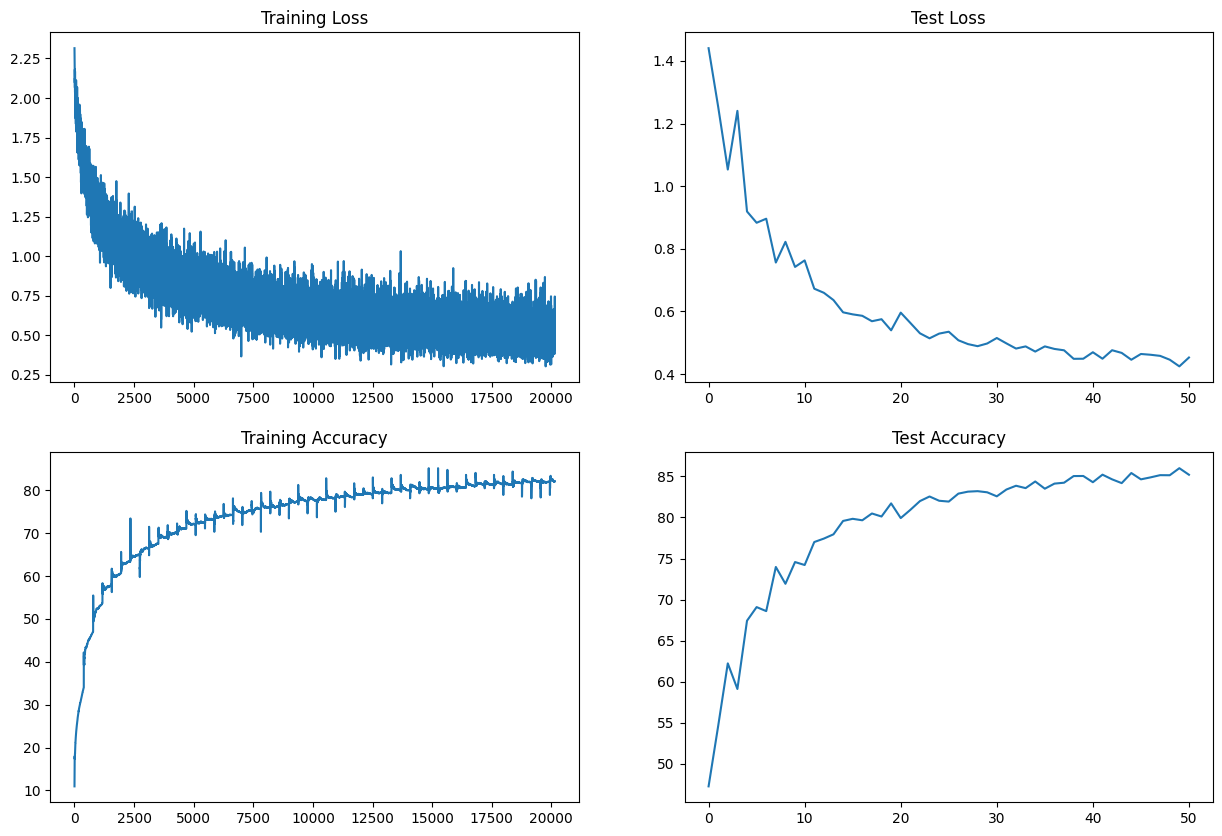

In [18]:
train_losses = [t_items.item() for t_items in train_losses]
plot_graphs(train_losses, train_acc, test_losses ,test_acc)

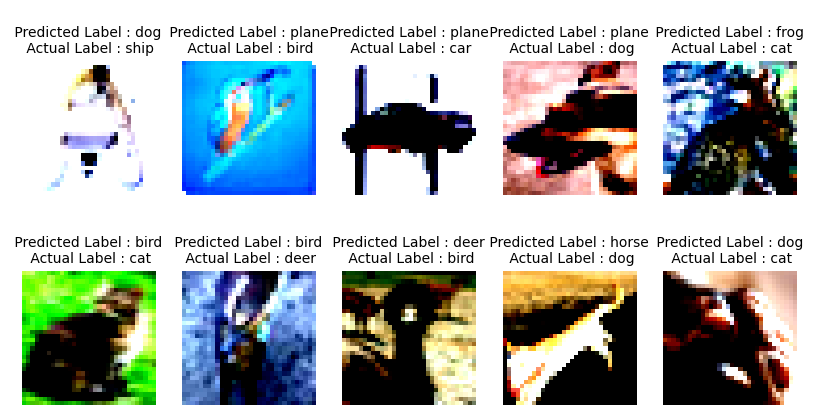

In [19]:
wrong_prediction_list = []
model1.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model1(images)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    match = pred.eq(labels.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(match):
        if(i == False):
            wrong_prediction_list.append((images[j], pred[j].item(), labels[j].item()))
display_incorrect_images(wrong_prediction_list, n=10 )